# CAR T Model

### How to run the notebook

This notebook simulates the phenomenological model of immunogenic cell death (ICD) using UPMaBoSS approach.
This notebook can be launched using the Docker image of CoLoMoTo:

    $docker pull colomoto/colomoto-docker

or by creating a conda environment with the following command:

    $conda create -n umb -c colomoto -c potassco pymaboss notebook seaborn ginsim-python

To launch this notebook, type the command:

    $conda activate umb
    $jupyter notebook
    

### Biological questions that the model should answer

What we want to do simulate and what we need to check:

- how to simulate a non-effective treatment? What are the read-outs?

- what is different between T cells and CAR T cells?

- what is the initial proportion of cells? 10% CAR T, 90% Tumour cells?

- What about the competition between CTLA4 and CD28 to bind to CD80_86?

- Test the impact of the initial CAR T population size: 10% and 25% seem to have an impact on its efficacy as they show differences in TA off. 


Attention: every time the simulations are run, a folder is created. If the simulations are run multiple times, t

In [1]:
#import ginsim
import maboss # for (UP)MaBoSS
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for plotting
import time # for measuring simluation time
plt.rcParams.update({'font.size': 16})

The network corresponding to the model that we are analysing can be visualized as follows. It was built with GINsim but cannot be simulated with GINsim because of the cell-cell communication. The rectangles concern the entities that are secreted or expressed inthe tumours. Others are related to the CAR T cell regulation.  

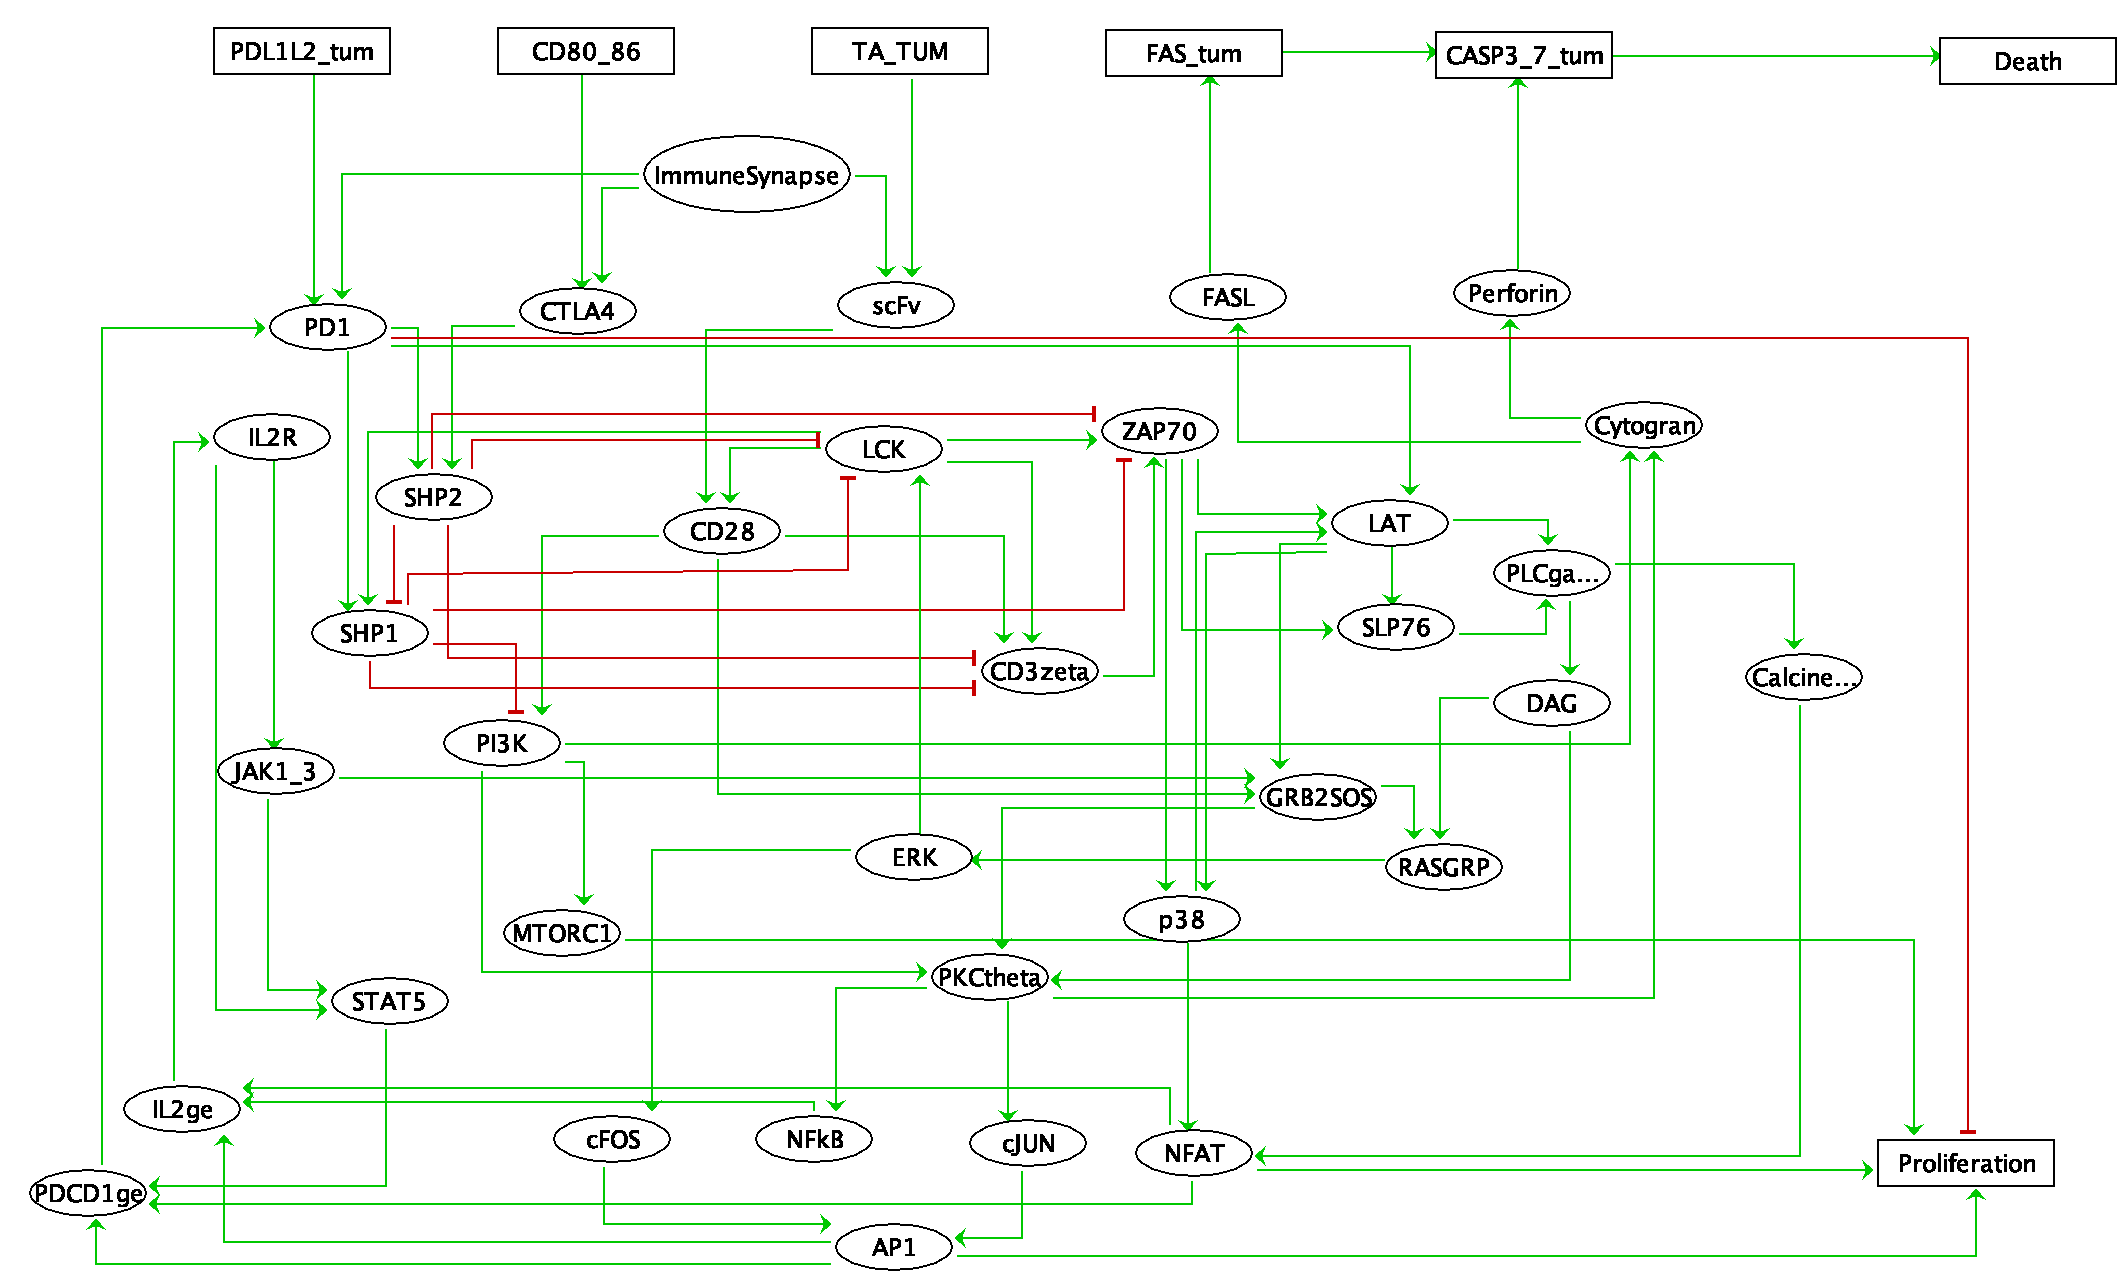

## Model files

In [2]:
bnd = '../Models/CART.bnd'
cfg = '../Models/CART.cfg'
upp = '../Models/CART.upp'

In [3]:
maboss_model = maboss.load(bnd,cfg)

In [4]:
maboss_model.network.set_istate('SCFV', [0,1])
#maboss_model.network.set_istate('LCK', [0,1])
maboss_model.param["$Initial_CART"]=0.4
maboss_model.param["$Initial_TUM"]=0.6

In [5]:
#model_maboss.update_parameters($Trans=1)

## Simulation of WT model

In [6]:
up_maboss_model = maboss.UpdatePopulation(maboss_model,upp) # create UPMaBoSS model

In [7]:
#start = time.time()
res_up_model = up_maboss_model.run("ResUpModel",overwrite=True) # run simulation, put intermediate MaBoSS steps in ResUpModel folder
res_up_model = up_maboss_model.run()
#stop = time.time()
#duration = (stop-start)/60
#print("exec. time: ",duration," mins")

In [8]:
table_res = res_up_model.get_nodes_stepwise_probability_distribution(('TUM','CART','CASP3_tum','FAS_tum','Proliferation','Perforin','NFAT','AP1','Division','Death','TA_tum','IS_tum','CD3zeta','LCK','ZAP70','SHP1','SLP76','ERK','CFOS'))

In [9]:
#table_res.nodes_list_stepwise_probability_distribution = None

### Plot time dependent cell types 

In [10]:
sns.set_style("white")
colormap_scale = sns.light_palette("black", as_cmap=True)
colormap_ratios = sns.diverging_palette(240, 0, center='light', as_cmap=True)
def save_figure(figure, title):
    figure.savefig("%s.pdf" % title, bbox_inches="tight")

This figure shows the temporal evolution of the cell types

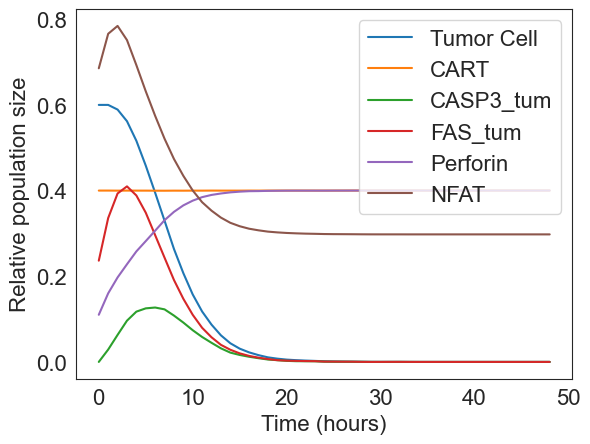

In [11]:
figure_res = plt.figure()
plt.plot(table_res['PopRatio']*table_res['TUM'],label="Tumor Cell")
plt.plot(table_res['PopRatio']*table_res['CART'],label="CART")
plt.plot(table_res['PopRatio']*table_res['CASP3_tum'],label="CASP3_tum")
plt.plot(table_res['PopRatio']*table_res['FAS_tum'],label="FAS_tum")
plt.plot(table_res['PopRatio']*table_res['Perforin'],label="Perforin")
#plt.plot(table_res['PopRatio']*table_res['AP1'],label="AP1")
plt.plot(table_res['PopRatio']*table_res['NFAT'],label="NFAT")
#plt.plot(table_res['PopRatio']*table_res['Proliferation'],label="Prolif")
plt.ylabel("Relative population size")
plt.xlabel("Time (hours)")
plt.legend()
save_figure(figure_res,"Entities")

In [12]:
#maboss_model.print_cfg()

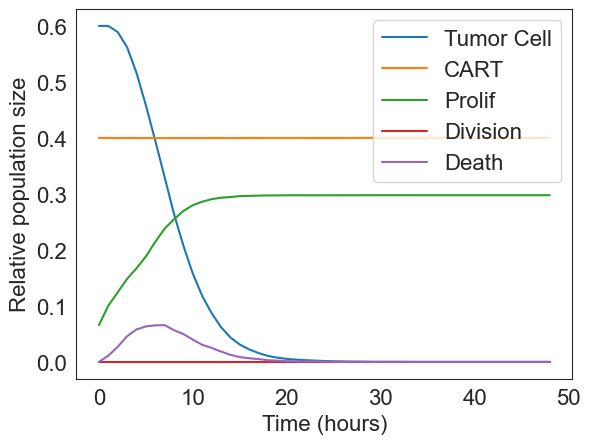

In [13]:
figure_res_2 = plt.figure()
plt.plot(table_res['PopRatio']*table_res['TUM'],label="Tumor Cell")
plt.plot(table_res['PopRatio']*table_res['CART'],label="CART")
plt.plot(table_res['PopRatio']*table_res['Proliferation'],label="Prolif")
plt.plot(table_res['PopRatio']*table_res['Division'],label="Division")
plt.plot(table_res['PopRatio']*table_res['Death'],label="Death")
plt.ylabel("Relative population size")
plt.xlabel("Time (hours)")
plt.legend()
#save_figure(figure_res_2,"CellTypes")

### Plot entities of the initial Shah model

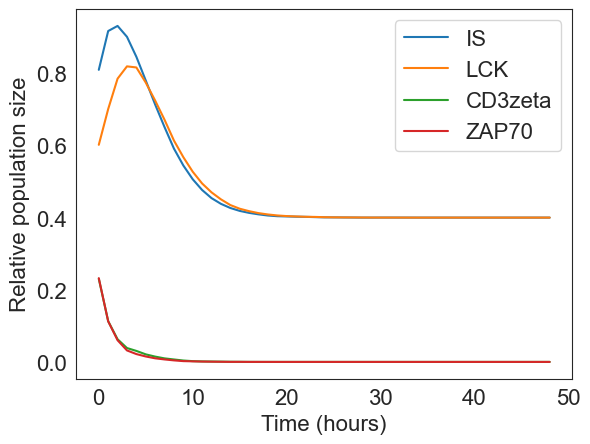

In [14]:
figure_res_3 = plt.figure()
#plt.plot(table_res3['PopRatio']*table_res3['TA_tum'],label="TA")
plt.plot(table_res['PopRatio']*table_res['IS_tum'],label="IS")
plt.plot(table_res['PopRatio']*table_res['LCK'],label="LCK")
plt.plot(table_res['PopRatio']*table_res['CD3zeta'],label="CD3zeta")
plt.plot(table_res['PopRatio']*table_res['ZAP70'],label="ZAP70")
plt.ylabel("Relative population size")
plt.xlabel("Time (hours)")
plt.legend()
#save_figure(figure_res_2,"CellTypes")

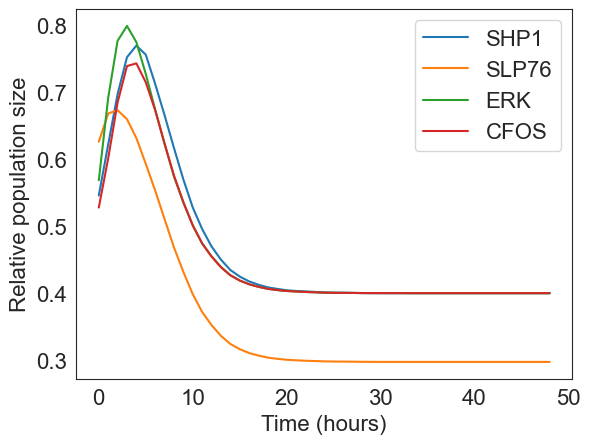

In [15]:
figure_res4 = plt.figure()
plt.plot(table_res['PopRatio']*table_res['SHP1'],label="SHP1")
plt.plot(table_res['PopRatio']*table_res['SLP76'],label="SLP76")
plt.plot(table_res['PopRatio']*table_res['ERK'],label="ERK")
plt.plot(table_res['PopRatio']*table_res['CFOS'],label="CFOS")
#plt.plot(table_res['PopRatio']*table_res['AP1'],label="AP1")
plt.ylabel("Relative population size")
plt.xlabel("Time (hours)")
plt.legend()
#save_figure(figure_res_2,"CellTypes")

### Mutant simulation: TA OFF

In [16]:
model_TA_off = maboss.copy_and_mutate(maboss_model, ["TA_tum"], 'OFF')
up_TA_model = maboss.UpdatePopulation(model_TA_off,upp) # create UPMaBoSS model

In [17]:
#start = time.time()
res_up_model = up_TA_model.run() # run simulation, put intermediate MaBoSS steps in ResUpModel folder
#stop = time.time()
#duration = (stop-start)/60
#print("exec. time: ",duration," mins")

In [18]:
table_res_TA = res_up_model.get_nodes_stepwise_probability_distribution(('TUM','CART','CASP3_tum','FAS_tum','Proliferation','Perforin','NFAT','AP1','Division','Death'))
#table_res_TA.nodes_list_stepwise_probability_distribution = None

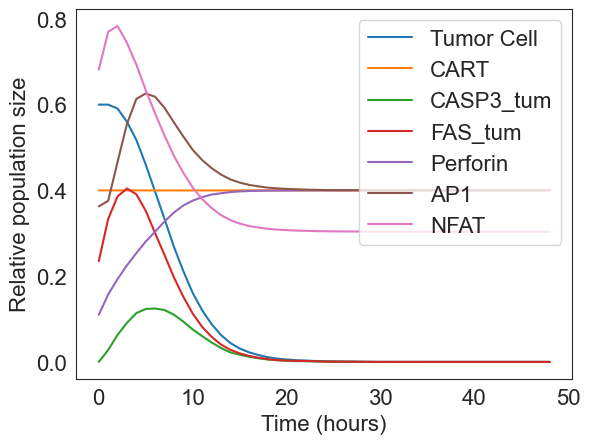

In [19]:
figure_res = plt.figure()
plt.plot(table_res_TA['PopRatio']*table_res_TA['TUM'],label="Tumor Cell")
plt.plot(table_res_TA['PopRatio']*table_res_TA['CART'],label="CART")
plt.plot(table_res_TA['PopRatio']*table_res_TA['CASP3_tum'],label="CASP3_tum")
plt.plot(table_res_TA['PopRatio']*table_res_TA['FAS_tum'],label="FAS_tum")
plt.plot(table_res_TA['PopRatio']*table_res_TA['Perforin'],label="Perforin")
plt.plot(table_res_TA['PopRatio']*table_res_TA['AP1'],label="AP1")
plt.plot(table_res_TA['PopRatio']*table_res_TA['NFAT'],label="NFAT")
#plt.plot(table_res_TA['PopRatio']*table_res_TA['Proliferation'],label="Prolif")
plt.ylabel("Relative population size")
plt.xlabel("Time (hours)")
plt.legend()
save_figure(figure_res,"Entities_TA")

The time of death is dealyed slightly but cells still die. Should we change the initial conditions? Should we mutate something else to simulate the T cells vs. CAR T cells? 

### Mutant simulation IL2 ON

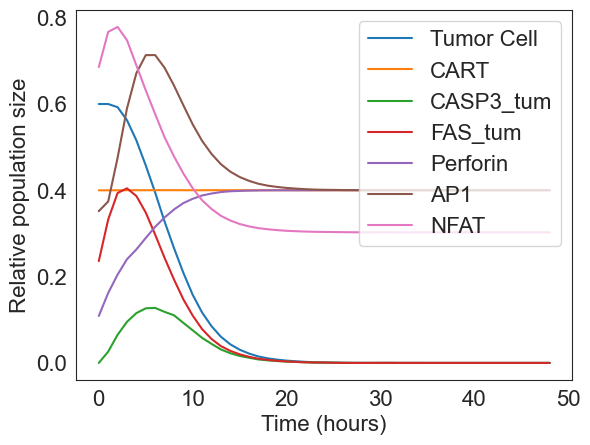

In [20]:
## create mutant
model_IL2_off = maboss.copy_and_mutate(maboss_model, ["IL2R"], 'ON')
up_IL2_model = maboss.UpdatePopulation(model_IL2_off,upp) # create UPMaBoSS model

## simulate model
#sIL2rt = time.time()
res_up_model = up_IL2_model.run() # run simulation, put intermediate MaBoSS steps in ResUpModel folder
#stop = time.time()
#duration = (stop-sIL2rt)/60
#print("exec. time: ",duration," mins")

IL2ble_res_IL2 = res_up_model.get_nodes_stepwise_probability_distribution(('TUM','CART','CASP3_tum','FAS_tum','Proliferation','Perforin','NFAT','AP1','Division','Death'))
#IL2ble_res_IL2.nodes_list_stepwise_probability_distribution = None

figure_res = plt.figure()
plt.plot(IL2ble_res_IL2['PopRatio']*IL2ble_res_IL2['TUM'],label="Tumor Cell")
plt.plot(IL2ble_res_IL2['PopRatio']*IL2ble_res_IL2['CART'],label="CART")
plt.plot(IL2ble_res_IL2['PopRatio']*IL2ble_res_IL2['CASP3_tum'],label="CASP3_tum")
plt.plot(IL2ble_res_IL2['PopRatio']*IL2ble_res_IL2['FAS_tum'],label="FAS_tum")
plt.plot(IL2ble_res_IL2['PopRatio']*IL2ble_res_IL2['Perforin'],label="Perforin")
plt.plot(IL2ble_res_IL2['PopRatio']*IL2ble_res_IL2['AP1'],label="AP1")
plt.plot(IL2ble_res_IL2['PopRatio']*IL2ble_res_IL2['NFAT'],label="NFAT")
#plt.plot(IL2ble_res_IL2['PopRatio']*IL2ble_res_IL2['Proliferation'],label="Prolif")
plt.ylabel("Relative population size")
plt.xlabel("Time (hours)")
plt.legend()
save_figure(figure_res,"Entities_IL2")

IL2ge ON or OFF has no effect. If IL2R is over activated then AP1 is higher but no impact on the time of tumour death

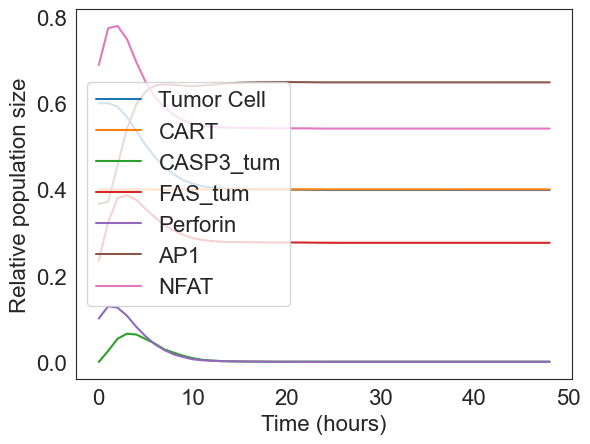

In [21]:
## create mutant
model_CD28_off = maboss.copy_and_mutate(maboss_model, ["CD28"], 'OFF')
up_CD28_model = maboss.UpdatePopulation(model_CD28_off,upp) # create UPMaBoSS model

## simulate model
#sCD28rt = time.time()
res_up_model = up_CD28_model.run() # run simulation, put intermediate MaBoSS steps in ResUpModel folder
#stop = time.time()
#duration = (stop-sCD28rt)/60
#print("exec. time: ",duration," mins")

CD28ble_res_CD28 = res_up_model.get_nodes_stepwise_probability_distribution(('TUM','CART','CASP3_tum','FAS_tum','Proliferation','Perforin','NFAT','AP1','Division','Death'))
#CD28ble_res_CD28.nodes_list_stepwise_probability_distribution = None

figure_res = plt.figure()
plt.plot(CD28ble_res_CD28['PopRatio']*CD28ble_res_CD28['TUM'],label="Tumor Cell")
plt.plot(CD28ble_res_CD28['PopRatio']*CD28ble_res_CD28['CART'],label="CART")
plt.plot(CD28ble_res_CD28['PopRatio']*CD28ble_res_CD28['CASP3_tum'],label="CASP3_tum")
plt.plot(CD28ble_res_CD28['PopRatio']*CD28ble_res_CD28['FAS_tum'],label="FAS_tum")
plt.plot(CD28ble_res_CD28['PopRatio']*CD28ble_res_CD28['Perforin'],label="Perforin")
plt.plot(CD28ble_res_CD28['PopRatio']*CD28ble_res_CD28['AP1'],label="AP1")
plt.plot(CD28ble_res_CD28['PopRatio']*CD28ble_res_CD28['NFAT'],label="NFAT")
#plt.plot(CD28ble_res_CD28['PopRatio']*CD28ble_res_CD28['Proliferation'],label="Prolif")
plt.ylabel("Relative population size")
plt.xlabel("Time (hours)")
plt.legend()
save_figure(figure_res,"Entities_CD28")